# 셸로우 포커스 사진

## 1. 라이브러리 임포트

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (10,8)

## 2. 모델 로드

In [2]:
# 저장할 파일 이름을 결정합니다
root_path = os.getenv('HOME')+'/aiffel/human_segmentation/'

model_dir = os.path.join(root_path, 'models')
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델 파일 중복다운로드 방지
if not os.path.isfile(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

## 3. 합성클래스 선언

In [3]:
class ObjectMask:
    CAT = (0, 0, 64)
    PERSON = (128, 128, 192)

class ShallowFocus:
    "Shallow Image Controller"

    images = dict()
    img_path = os.path.join(root_path, 'images')
    
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

    def __init__(self):
        pass
    
    def load_image(self, img_file, var, display=True):
        "image to cv2 obj"
        
        img_path = self._resize_image(img_file)
        self.images[var] = dict(
            cv2=cv2.imread(img_path),
            path=img_path,
        )

        if display:
            plt.imshow(cv2.cvtColor(self.images[var]['cv2'], cv2.COLOR_BGR2RGB))
            plt.xlabel(f"Load image: {var}")
            plt.show()
        
        return self.images[var]

    def _img_path(self, img_file):
        "이미지 경로"

        return os.path.join(self.img_path, img_file)
    
    def _resize_image(self, img_file):
        "이미지를 최대 800px 크기로 리사이징"

        img_path = self._img_path(img_file)
        with Image.open(img_path) as im:
            w, h = im.size
            if max(w, h) > 800:
                im.thumbnail((800, 800))
                im.save(img_path)

        return img_path

    def segmentation(self, var, display=True):
        "모델로 이미지에서 개체검출"
        
        segvalues, self.images[var]['seg_output'] = model.segmentAsPascalvoc(self.images[var]['path'])
        self.images[var]['label'] = [self.LABEL_NAMES[cid] for cid in segvalues['class_ids']]
        if display:
            plt.imshow(self.images[var]['seg_output'])
            plt.show()
        print(f"{var} 이미지엔 [{', '.join(self.images[var]['label'])}](이)가 검출되었습니다")

    def seg_map(self, var, seg_color, display=True):
        "특정 개체 배경과 구분"

        seg_map = np.all(self.images[var]['seg_output']==seg_color, axis=-1)
        plt.subplot(1, 2, 1)
        plt.imshow(seg_map, cmap='gray')

        img_show = self.images[var]['cv2'].copy()

        # True과 False인 값을 각각 255과 0으로 바꿔줍니다
        self.images[var]['mask'] = seg_map.astype(np.uint8) * 255

        # 255와 0을 적당한 색상으로 바꿔봅니다
        color_mask = cv2.applyColorMap(self.images[var]['mask'], cv2.COLORMAP_JET)

        # 원본 이미지와 마스크를 적당히 합쳐봅니다
        # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

        if display:
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

            plt.tight_layout()
        
        return img_show

    def blur(self, var, blur_size=30, display=True):
        "원본 블러처리"

        img_orig_blur = cv2.blur(self.images[var]['cv2'], (blur_size, blur_size))  
        if display:
            plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
            plt.show()
        
        return img_orig_blur
    
    def mask(self, var, background, display=True):
        "개체 탐지영역과 배경 합성"

        img_mask_color = cv2.cvtColor(self.images[var]['mask'], cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        img_bg_concat = cv2.bitwise_and(background, img_bg_mask)
        img_concat = np.where(img_mask_color==255, self.images[var]['cv2'], img_bg_concat)

        if display:
            # 배경 출력
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))

            # 합성이미지 출력
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
            plt.tight_layout()
        
        return img_concat

img = ShallowFocus()

## 4. 인물사진

### 4-1. 대상 이미지 로드

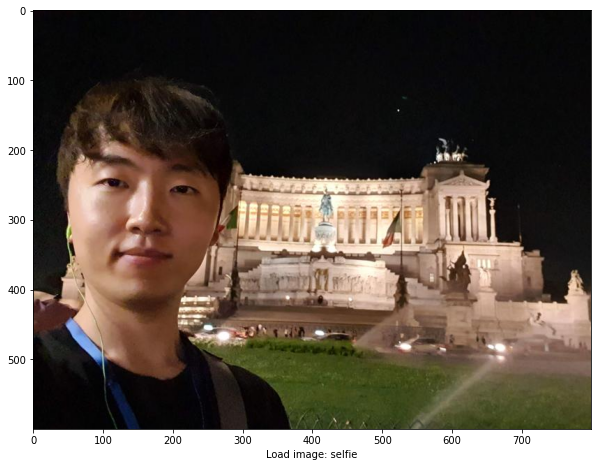

In [4]:
_ = img.load_image('my_self.jpg', 'selfie')  # my_self.jpg 'selfie' 키로 로드

### 4-2. 이미지에서 개체 검출

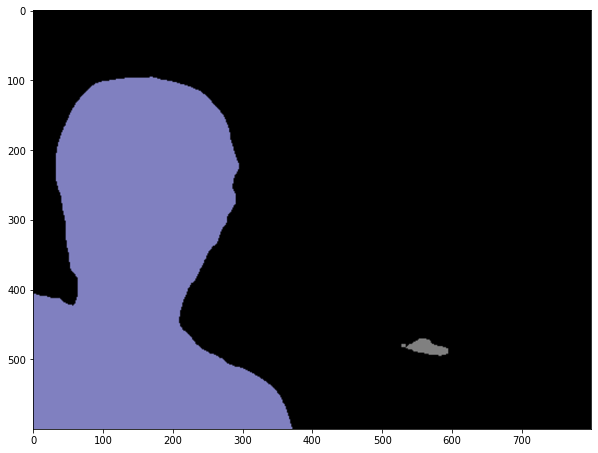

selfie 이미지엔 [background, car, person](이)가 검출되었습니다


In [5]:
img.segmentation('selfie')

### 4-3. 이미지에서 배경/인물 구분

> 인물의 경계가 확실하진 못하다

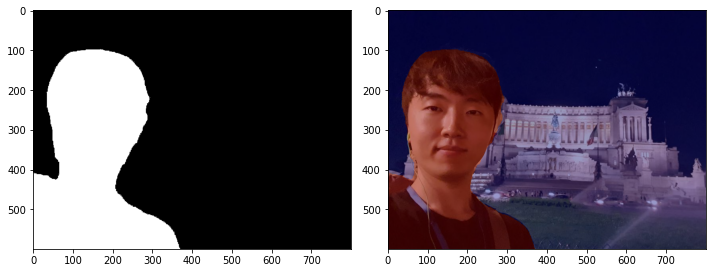

In [6]:
person_mask = img.seg_map('selfie', ObjectMask.PERSON)

### 4-4. 배경 블러처리

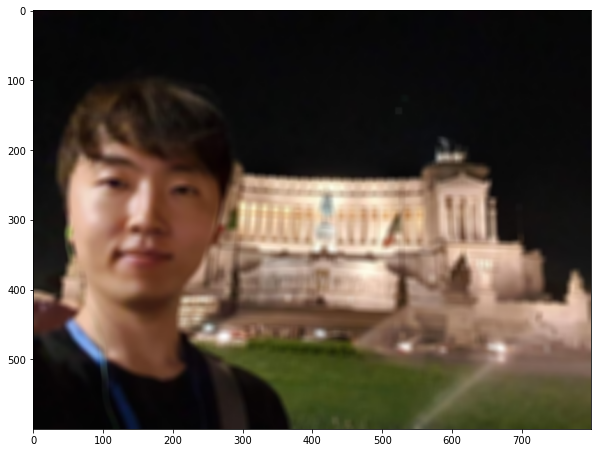

In [7]:
person_blur = img.blur('selfie', 10)

### 4-5. 블러배경 마스크와 합성

> 확실히 인물에 포커스가 더 잘 간다

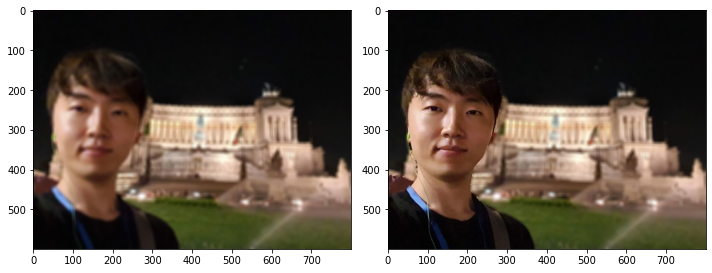

In [8]:
result_person_blur = img.mask('selfie', person_blur)

## 5. 고양이 사진

### 5-1. 대상 이미지 로드

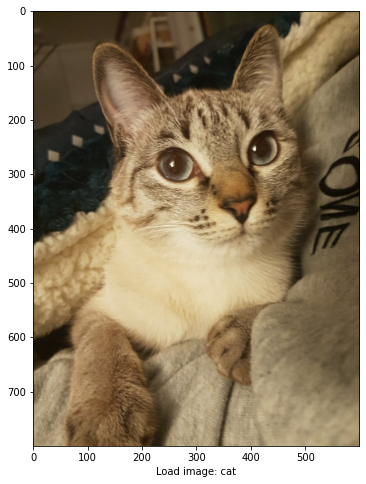

In [9]:
_ = img.load_image('my_cat.jpg', 'cat')  # my_cat.jpg 'cat' 이름으로 로딩

### 5-2. 이미지에서 개체 검출

> 고양이의 왼발이 옷에 가려져서 한 개체로 인식하지 못할 줄 알았는데 꽤 근사하게 검출된다

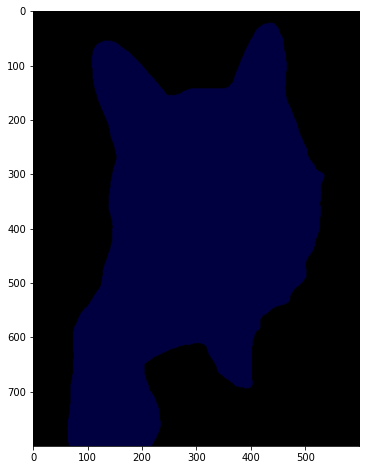

cat 이미지엔 [background, cat](이)가 검출되었습니다


In [10]:
img.segmentation('cat')

### 5-3. 이미지에서 배경/고양이 구분

> 역시 경계가 100% 정확하진 않다

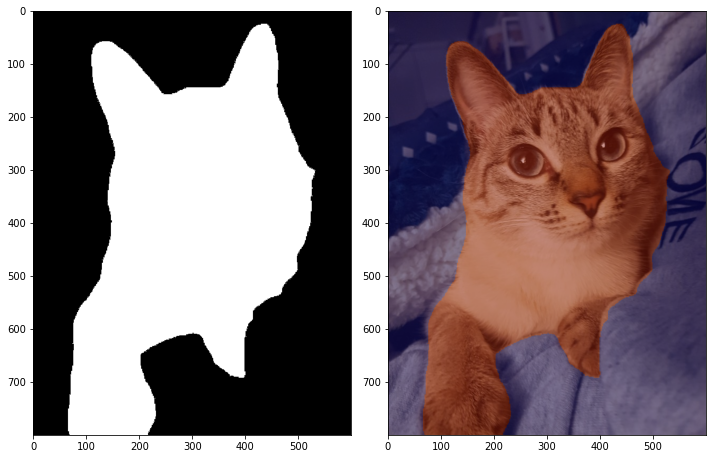

In [11]:
_ = img.seg_map('cat', ObjectMask.CAT)

### 5-4. 배경 블러처리

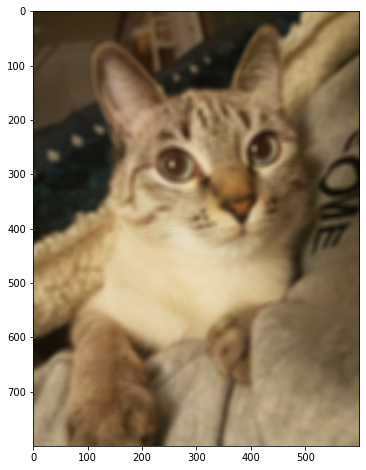

In [12]:
cat_blur = img.blur('cat', 11)

### 5-5. 블러배경 마스크와 합성

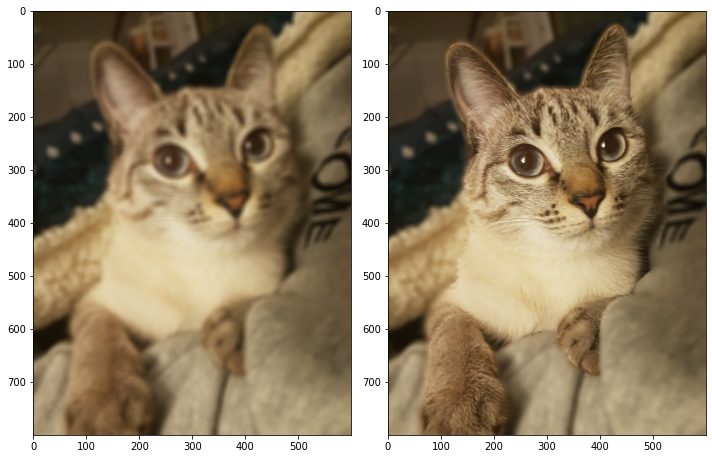

In [13]:
result_cat_blur = img.mask('cat', cat_blur)

## 6. 배경 변경하기

### 6-1. 배경 이미지 로드

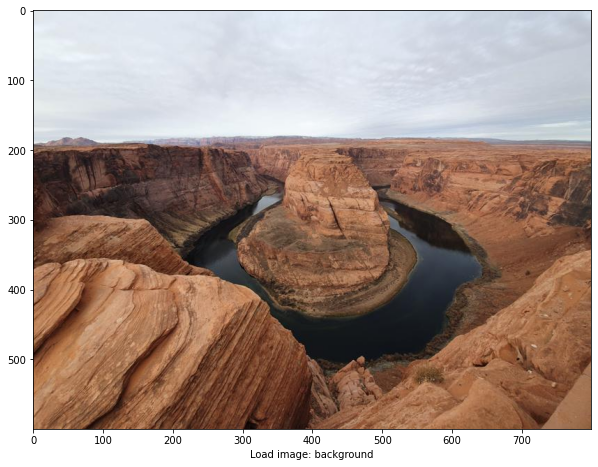

In [14]:
bg = img.load_image('my_bg.jpg', 'background')  # my_bg.jpg 'background' 키로 로드

### 6-2. 인물 사진 로드

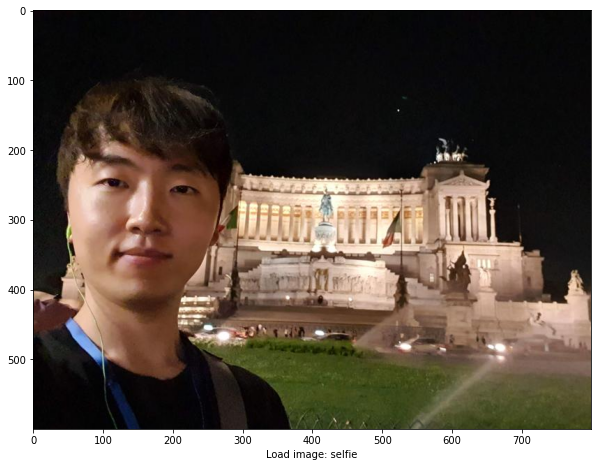

In [15]:
person_load = img.load_image('my_self.jpg', 'selfie')

### 6-3. 새로운 배경에 인물 합성

> 로마에서 미국으로 옮겨줬음

selfie 이미지엔 [background, car, person](이)가 검출되었습니다


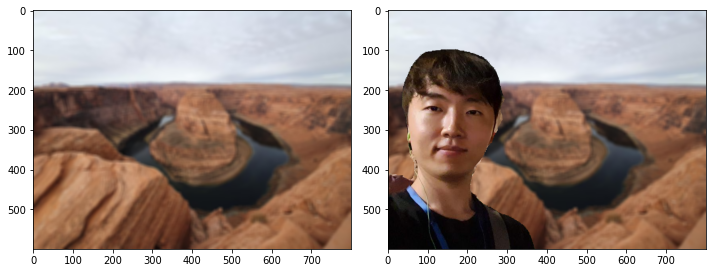

In [16]:
img.segmentation('selfie', display=False)
img_show = img.seg_map('selfie', ObjectMask.PERSON, display=False)
result_change_bg = img.mask('selfie', img.blur('background', 10, display=False))

## 7. 문제점들

### 7-1. 불완전 탐지

> 인물과 배경의 경계가 모호해서인지 인물만 확실히 구분해내진 못했다. 목과 어깨뒤로 배경이 함께 포함됐다

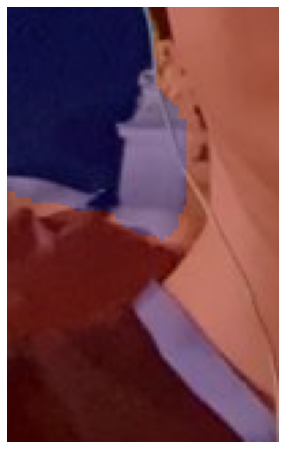

In [17]:
plt.imshow(cv2.cvtColor(img_show[340:500, 0:100], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 7-2. 경계선이 너무 선명함

> 마스크 처리를 할 때 흑/백으로 구분하면서 경계선이 각지고 뚜렷해서 배경과 합성시 어색해진다.

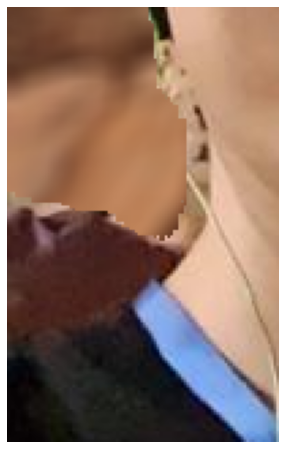

In [18]:
seg_map = np.all(person_load['seg_output']==ObjectMask.PERSON, axis=-1)
plt.imshow(seg_map, cmap='gray')
#result_change_bg

plt.imshow(cv2.cvtColor(result_change_bg[340:500, 0:100, ], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 8. 회고

* 이미지에서 개체를 탐지해내는 Semantic Segmentation 모델을 사용해봤다
* 이미지 내에서의 개체를 꽤 잘 찾아내준다. 하지만 배경만 블러처리 한다고 해서 좋은 솔루션이 될 것 같지는 않다
    1. 모델이 경계를 더 확실히 구분해낼 수 있어야 하고
    2. 마스크의 흑/백 경계를 좀더 부드럽게 처리(blur) 해주면 훨씬 도움이 될 것 같다
    3. 오히려 블러강도를 심하게 주는 것 보다 약하게 적용하면 경계의 어색함이 덜한 것 같다